In [1]:
import sys, os
PROJECT_ROOT = r"D:\bhermosi\chestxsim-project" 
SRC = os.path.join(PROJECT_ROOT, "src")
if SRC not in sys.path:
    sys.path.insert(0, SRC)

# Reconstruction Module — Usage Guide 

This notebook introduces the **reconstruction module** in ChestXSim and demonstrates how to recosntruct a volume from Digital Chest Tomosynthesis (DCT) projections.  
It shows how to:

- from Polychromatic projections vs Monocrhomatic projections 
- using tradional algorithm FDK and iterative SART


## Overview

The **reconstruction module** follows the same design philosophy as the projection module.  
Each reconstruction algorithm is implemented as a **step class** that operates on a `volumeData` object and automatically records its parameters in the `metadata`. These require a configured **operator** initialized from a system geometry instance (e.g., `TomoGeometry` for DCT). 


### Operator Recap

The reconstruction step uses the same **operator** interface (`opt`) as the projection module, providing a unified API for forward and backward operations:

- `project(volume3d, voxel_size)` → generates projections `(W, H, Angles)`  
- `backproject(projs, reco_dim, reco_vx_size)` → performs backprojection or full reconstruction `(W, H, D)`

The **`Astra_OP`** class serves as the **abstract base wrapper** for ASTRA within ChestXSim, defining the core methods for initializing geometry, allocating ASTRA projectors, and managing GPU execution.

The **`Astra_Tomo`** subclass provides the **concrete DCT implementation**, configuring ASTRA’s CUDA-based 3D cone-beam geometry:

- **Forward projection:** `FP3D_CUDA`  
- **Backprojection:** `BP3D_CUDA`


### Available Reconstruction Steps

>Unlike the preprocessing or projection modules, the reconstruction module focuses solely on the **reconstruction algorithms** themselves. Any additional post-processing can be implemented as separate steps following the typical caller interface design. 


| Step class | Algorithm | Description |
|-------------|------------|--------------|
| **`BackProject`** | Direct Backprojection | Simple backprojection from raw projections. Useful for testing geometry setup. |
| **`FDK`** | Filtered Backprojection (Feldkamp–Davis–Kress) | Classical analytical cone-beam reconstruction. Includes ramp filtering. |
| **`SART`** | Simultaneous Algebraic Reconstruction Technique | Iterative reconstruction. |

### Analytical Reconstruction - FDK 

In [2]:
from chestxsim.core import TomoGeometry
from chestxsim.io import RawReader
from chestxsim.wrappers.astra import Astra_Tomo
from chestxsim.utility import plot
from chestxsim.core.device import xp

# --- Load 3D projections 
# proj_case_folder =  r"D:\bhermosi\chestxsim-project\examples\volumes\NoisyProjections\NODULO_S18_S20"
# reader = RawReader()
# projs = reader.read(proj_case_folder)
# print(projs.volume.shape)

from chestxsim.io import DicomReader
from chestxsim.preprocessing.steps import (
    BedRemover, AirCropper, VolumeExtender, TissueSegmenter, UnitConverter
)
from chestxsim.utility import plot
from chestxsim.projection import Projection


# --- Load DICOM case as volumeData ---
path_to_dicom = r"D:\bhermosi\chestxsim-project\inputs\NODULO\S18\S20"
reader = DicomReader(convert_to_HU=True, clip_values=[-1000, 3000])
ct_data = reader.read(path_to_dicom)
print("Step 0 — DICOM volume loaded.")

# --- 1) Remove bed (analytical) — for DL: omit threshold and pass model_name ---
step_bed = BedRemover(threshold=-200, save_mask=False)
ct_bed_removed = step_bed(ct_data)
print("Step 1 — Bed removal done.")

# --- 2) Crop empty air regions along x (axis=1) ---
step_air = AirCropper(axis=1, tol=5, delta=3, channel=0)
ct_air_cropped = step_air(ct_bed_removed)
print("Step 2 — Air cropping done.")

# --- 3) Extend the volume to a target height (mm) ---
step_ext = VolumeExtender(target_height=575, chest_center=150)
ct_extended = step_ext(ct_air_cropped)
print("Step 3 — Volume extension done.")

# --- 4) Tissue segmentation (analytical) → stacked channels [bone, soft] ---
step_seg = TissueSegmenter(threshold=300, tissue_types=["bone", "soft"], save_masks=False)
ct_segmented = step_seg(ct_extended)
print("Step 4 — Tissue segmentation done.")

# --- 5) Convert units to linear attenuation coefficients (μ) ---
step_units_mu = UnitConverter(units="mu", voltage=120)
ct_mu = step_units_mu(ct_extended)
print("Step 5 — Unit conversion to μ done.")



from chestxsim.core.geometries import TomoGeometry
from chestxsim.wrappers.astra import Astra_Tomo

# Geometry (DCT)
geo = TomoGeometry(
    detector_size=(4288, 4288),
    pixel_size=(0.1, 0.1),
    binning_proj=8,
    SDD=1800.0,
    bucky=14.47,
    step=16.077,
    nstep=60
)

# Create the concrete operator from geometry
opt = Astra_Tomo(geometry=geo)

att_proj = Projection(opt, channel_wise=False)(ct_mu)


GPU detected: Using CuPy with 1 device(s), current device: 0
Step 0 — DICOM volume loaded.
Step 1 — Bed removal done.
Step 2 — Air cropping done.
Step 3 — Volume extension done.
Step 4 — Tissue segmentation done.
Step 5 — Unit conversion to μ done.
{'detector_size': (4288, 4288), 'pixel_size': (0.1, 0.1), 'binning_proj': 8, 'SDD': 1800.0, 'bucky': 14.47, 'step': 16.077, 'nstep': 60}


In [3]:
projs = att_proj
projs.metadata.init
# projs.metadata.step_outputs

{'voltage': 120.0,
 'slope': 1.0,
 'intercept': -1024.0,
 'ct_orig_shape': (512, 512, 276),
 'ct_orig_vx': (0.84, 0.84, 1.25)}

In [4]:
from chestxsim.reconstruction.steps import FDK
reco_vx = (1.25, 5.00, 1.25)

In [7]:
# arreglar esto en los readers generar campo de input siempre 
projs.metadata.step_outputs["input"] = projs.metadata.init

Using original volume mm settting `match_input = True`

mm (430.08, 430.08, 575.0)
reco_dim px (344, 86, 460)
110 74


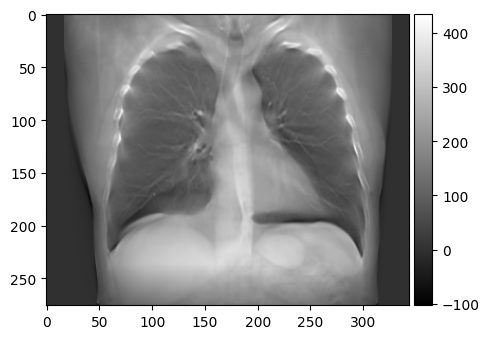

In [12]:
# reconstruct using original volume shape 
fdk_match  = FDK(opt=opt,
               match_input = True,
               reco_vx= reco_vx,
               filter_type="ramp",
               axis=1,
               padding=True)

out1 = fdk_match(projs)
plot(out1.volume.get()[:,40,:,0].T)


Using `reco_dim_px`

mm None
reco_dim px (350, 80, 200)


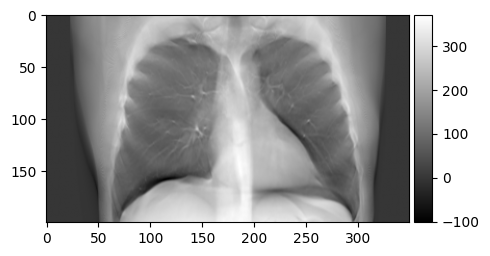

In [22]:
reco_dim_px = (350, 80, 200)
fdk_px= FDK(opt,
             reco_dim_px= reco_dim_px,
             reco_vx= reco_vx,
             filter_type="ramp")

out2 = fdk_px(projs)
plot(out2.volume.get()[:,30,:,0].T)

Using effective FOV from `Geometry` instance 